In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.io import ascii, fits
from astropy.table import Table
from astropy import units as u

from herschelhelp import cutouts_server as ctts

In [2]:
def find_ra_and_dec(colnames):
    raname = ''
    decname = ''
    for n,colname in enumerate(colnames):
        if colname.lower() == 'ra':
            raname = colname
        if colname.lower() == 'dec':
            decname = colname
        if (raname != '') & (decname != ''):
            return(raname,decname)

In [3]:
def get_pix_length(image,wcs,box_length,ra_cent,dec_cent):
    #returns the number of pixels needed to encompass a box of given boxlength in degrees
    
    pix_centx, pix_centy = wcs.wcs_world2pix(ra_cent,dec_cent,0,ra_dec_order=True)
    pixscale_x, pixscale_y = np.array(wcs.wcs_pix2world(pix_centx,pix_centy,0,ra_dec_order=True)) - np.array(wcs.wcs_pix2world(pix_centx+1,pix_centy+1,0,ra_dec_order=True))

    pix_num_x = box_length/pixscale_x
    pix_num_y = box_length/pixscale_y
    
    return(abs(pix_num_x),abs(pix_num_y))

In [4]:
def cat_plot(ra,dec,wcs,ax,marker='dot',col='red',size=10,colz=False,redshift=None):
    pixx,pixy = wcs.wcs_world2pix(ra,dec,0,ra_dec_order=True)
    if colz==True:
        print('using redshift')
        col = redshift

    colbar = ax.scatter(ra,dec,marker=marker,c=col,s=size,cmap='Spectral',transform=ax.get_transform('world'))
    return(colbar)

In [5]:
def image_plot(image,ra,dec,wcs,box_length,fig):
    '''
    create a matplotlib image plot of a cutout of the given image
    box_length: give the boxlength in arcseconds
    '''
    cmap = 'binary'
    origin = 'lower'
    
    c = SkyCoord(ra*u.degree,dec*u.degree,unit='deg')
    length_x, length_y = get_pix_length(image,wcs,box_length,ra_cent,dec_cent)
    pix_cent_x, pix_cent_y = wcs.wcs_world2pix(ra,dec,0,ra_dec_order=True)
    pixscale = np.array(wcs.wcs_pix2world(0,0,0)) - np.array(wcs.wcs_pix2world(1,1,0))
    imgcut = Cutout2D(image, c, size=[box_length*u.degree,box_length*u.degree], wcs=wcs)
    wcscut = imgcut.wcs
    imgcut = imgcut.data

    vmin, vmax = ctts.cutout_scale(imgcut)
    ax = fig.add_subplot(111, projection=wcscut)

    ax.imshow(imgcut, vmax=vmax, vmin=vmin, cmap=cmap, interpolation='nearest', origin=origin)

    return(wcscut,ax)

In [6]:
def contour_plot(data,ra,dec,box_length,ax):
    
    image,wcs = data
    c = SkyCoord(ra*u.degree,dec*u.degree,unit='deg')
    length_x, length_y = get_pix_length(image,wcs,box_length,ra_cent,dec_cent)

    imgcut = Cutout2D(image, c, size=[box_length*u.degree,box_length*u.degree], wcs=wcs)
    wcscut = imgcut.wcs.celestial
    imgcut = imgcut.data
    vmin, vmax = ctts.cutout_scale(imgcut)
    
    ax.contour(imgcut,levels=np.linspace(vmin,vmax,5),colors='white',transform=ax.get_transform(wcscut))
    
    return(ax)

In [7]:
def plot_figure(image,cat,wcs,ra_cent,dec_cent,plot_params,contour_data=None):
    
    #unpack plot_params
    marker,col,size,box_length,use_redshift = plot_params.values()
    
    #plot the cutout of the image and return the axis and the wcs of the cutout
    fig = plt.figure(figsize=(10,10))
    length_x, length_y = get_pix_length(image,wcs,box_length,ra_cent,dec_cent)
    wcsimg,ax = image_plot(image,ra_cent,dec_cent,wcs,box_length,fig)
    
    #create the radio contour plot and superimpose it onot the image cutout
    if contour_data != None:
        ax = contour_plot(contour_data,ra_cent,dec_cent,box_length,ax)
        ax.set_xlim(0,length_y-1)
        ax.set_ylim(0,length_y-1)
    
    #select the sources within the cutout from the catalogue and plot them
    ramax = ra_cent + box_length/2/np.cos(box_length/2)
    ramin = ra_cent - box_length/2/np.cos(box_length/2)

    decmax = dec_cent + box_length/2
    decmin = dec_cent - box_length/2
    #print('ramax = {}\nramin = {}\ndecmax = {}\ndecmin = {}'.format(ramax,ramin,decmax,decmin))
    if type(cat) != list:
        raname,decname = find_ra_and_dec(catalogue.colnames)
        mask = (cat[raname]>ramin) & (cat[raname]<ramax)  &  (cat[decname]>decmin) & (cat[decname]<decmax)
        cat = cat[mask]
        print('plotting {} sources'.format(len(catalogue)))
        if plot_params['use_redshift']==False:
            cat_plot(cat[raname],cat[decname],wcsimg,ax,marker[0],col,size)
        else:
            colbar = cat_plot(cat[raname],cat[decname],wcsimg,ax,marker[0],col,size,colz=True,redshift=np.linspace(0,2,len(cat)))
            fig.colorbar(colbar)
    else:
        for n,catalogue in enumerate(cat):
            raname,decname = find_ra_and_dec(catalogue.colnames)
            mask = (catalogue[raname]>ramin) & (catalogue[raname]<ramax)  &  (catalogue[decname]>decmin) & (catalogue[decname]<decmax)
            catalogue = catalogue[mask]
            print('plotting {} sources'.format(len(catalogue)))
            if plot_params['use_redshift'][n]==False:
                cat_plot(catalogue[raname],catalogue[decname],wcsimg,ax,marker[n],col[n],size)
            else:
                colbar = cat_plot(catalogue[raname],catalogue[decname],wcsimg,ax,marker[n],col[n],size,colz=True,redshift=catalogue['redshift'])
                fig.colorbar(colbar)
            
        
    

    plt.show()
    

In [8]:
np.arange(0,2,len(cat))

NameError: name 'cat' is not defined

In [9]:
plot_params = {'marker':['o','v','s','+','X','d'],
              'col':['black','magenta'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[True,False]}

In [10]:
pswfits='../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/Lockman-SWIRE_SPIRE250_v1.0.fits'#SPIRE 250 map
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

masterlist = Table.read('../../../HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')
blind_source_list = Table.read('../../../HELP/dmu_products/dmu22/dmu22_Lockman-SWIRE/data/dmu22_XID+SPIRE_Lockman-SWIRE_BLIND_Matched_MF.fits')

fname = '../../../HELP/dmu_products/dmu12/data/lockman_full_ampphase1m_shift.app.restored.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not

In [11]:
plot_figure(im250,[masterlist,blind_source_list],w_250,161.455,57.754,plot_params,contour_data=[radim_data,radim_wcs])
#used to be ra=161 dec=59+1/120

NameError: name 'ra_cent' is not defined

<Figure size 720x720 with 0 Axes>

In [525]:
mask = blind_source_list['HELP_ID'] == ('HELP_BLIND_J104549.302+574514.428')
blind_source_list[mask]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE,FErr_BLIND_pix_SPIRE,flag,field
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,,,deg,deg,mJy,mJy,,
bytes33,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13
HELP_BLIND_J104549.302+574514.428,161.45542296535533,57.75400768232052,122.524055,122.748245,122.05929,127.964554,128.50264,127.01011,98.94515,101.098175,96.75875,-0.95680755,-1.7240368,-2.5719101,3.5583906,3.8906999,3.4247334,0.9993789,0.9990808,0.9994423,2000.0,2000.0,2000.0,1.0,1.0,0.73,True,True,True,120.31813372059285,3.2316502221596477,123.87246030935768,3.2213181821793784,101.60755874920173,3.1855056628530676,0.9576447948654356,1.0,161.45489417460428,57.75261970094089,110.60266927757276,3.083634828244391,0.0,Lockman-SWIRE


161.455
161.44666637730646
161.46333362269357
plotting 52 sources
          help_id               field     ... flag_cigale_ir flag_cigale_ironly
                                          ...                                  
--------------------------- ------------- ... -------------- ------------------
HELP_J104547.307+574519.924 Lockman SWIRE ...             -1                 -1
HELP_J104547.320+574500.259 Lockman SWIRE ...             -1                 -1
HELP_J104547.353+574508.130 Lockman SWIRE ...             -1                 -1
HELP_J104547.370+574459.180 Lockman SWIRE ...             -1                 -1
HELP_J104547.429+574510.006 Lockman SWIRE ...             -1                 -1
HELP_J104547.431+574508.059 Lockman SWIRE ...             -1                 -1
HELP_J104547.556+574503.691 Lockman SWIRE ...             -1                 -1
HELP_J104547.624+574458.073 Lockman SWIRE ...             -1                 -1
HELP_J104547.630+574541.031 Lockman SWIRE ...         

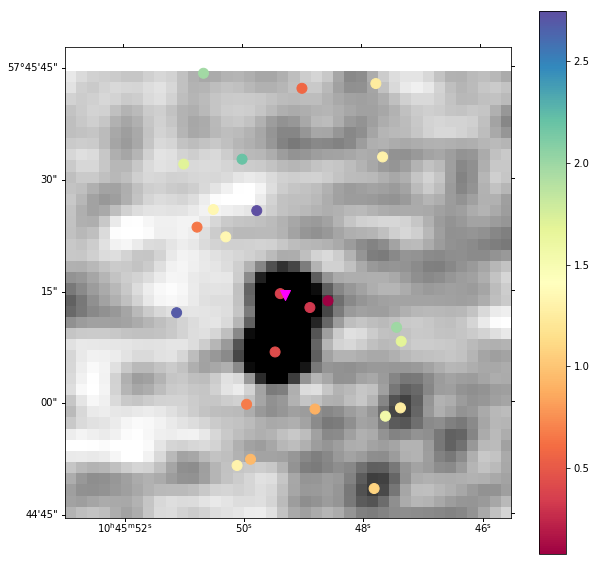

(None,)

In [552]:
plot_figure(radim_data,[masterlist,blind_source_list],radim_wcs,161.455,57.754,plot_params),#contour_data=[radim_data,radim_wcs])

In [553]:
mrr = Table.read('../MRR_SB.fits')

plotting 30 sources
using redshift
plotting 2 sources


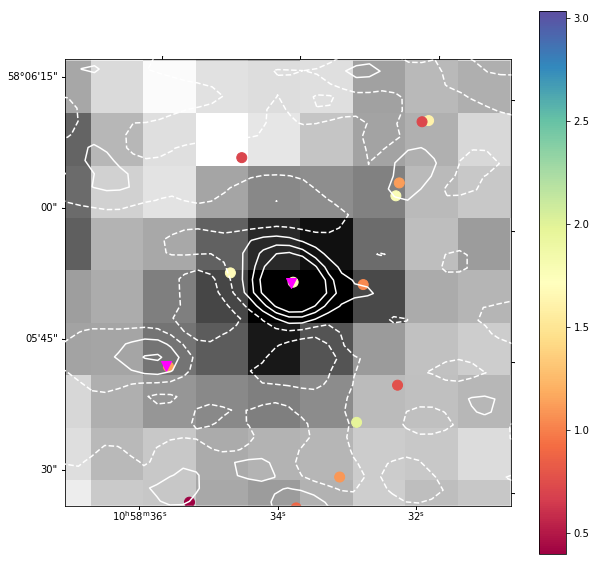

plotting 29 sources
using redshift
plotting 2 sources


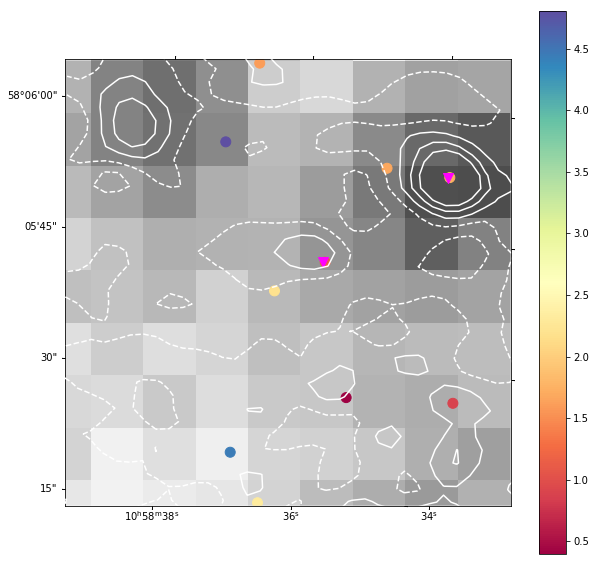

plotting 58 sources
using redshift
plotting 1 sources


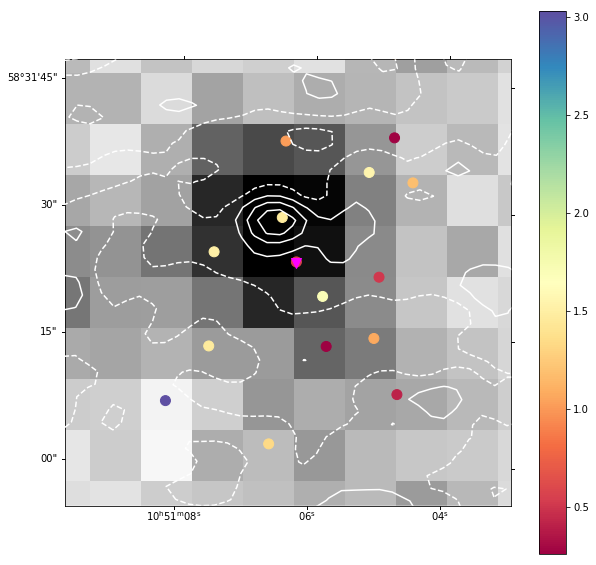

plotting 50 sources
using redshift
plotting 1 sources


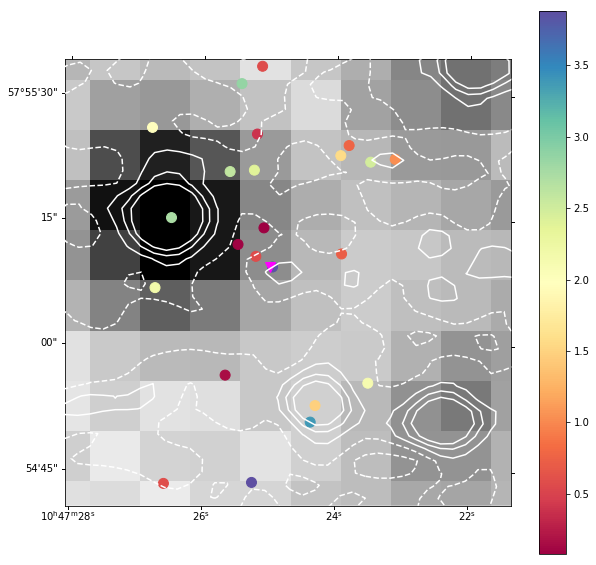

plotting 58 sources
using redshift
plotting 1 sources


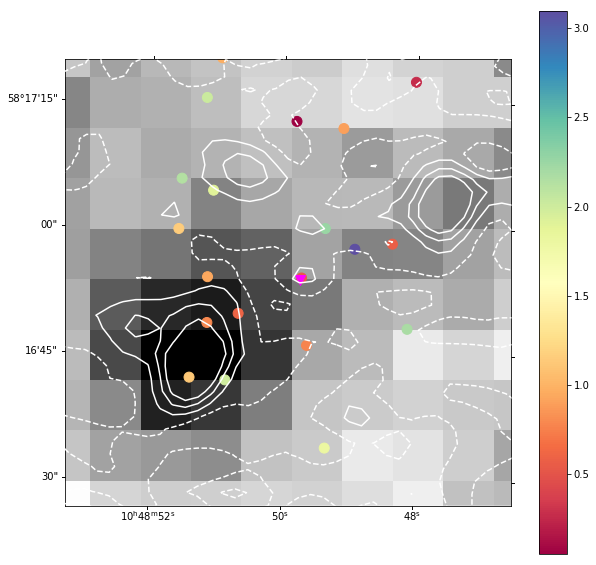

plotting 69 sources
using redshift
plotting 1 sources


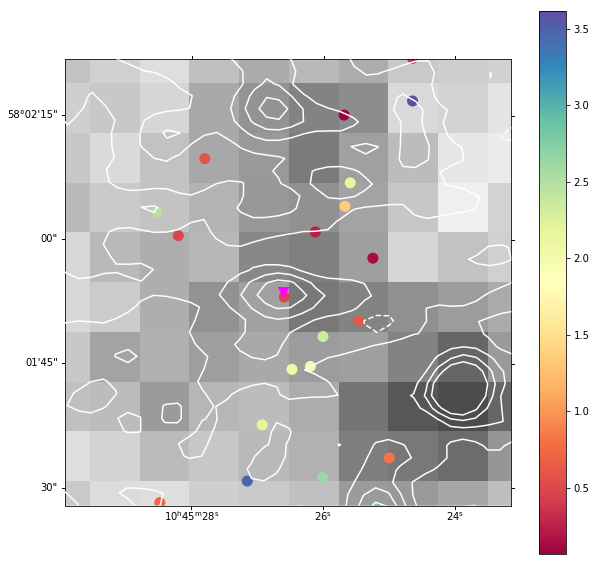

plotting 60 sources
using redshift
plotting 1 sources


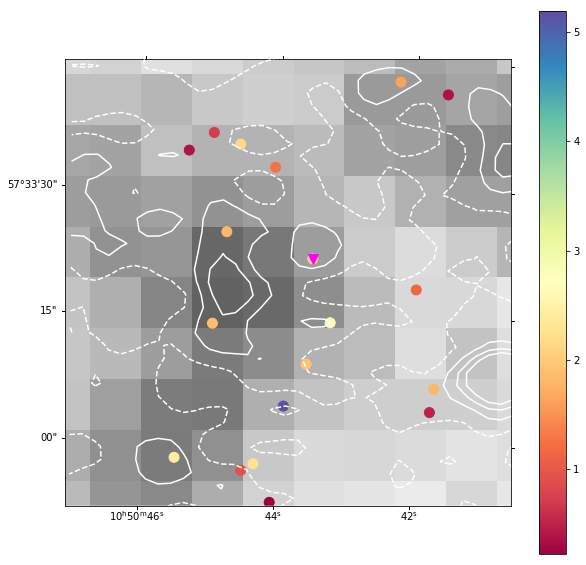

plotting 52 sources
using redshift
plotting 1 sources


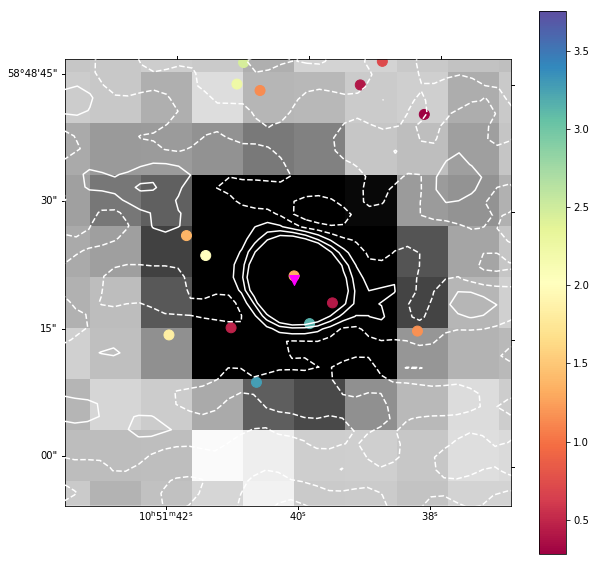

plotting 41 sources
using redshift
plotting 1 sources


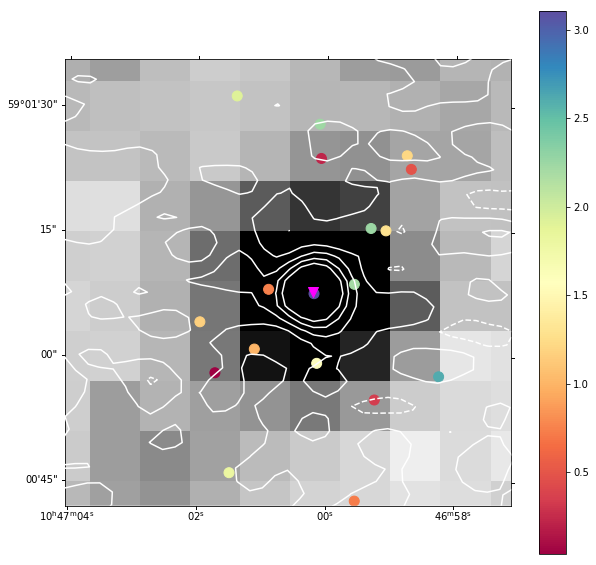

plotting 34 sources
using redshift
plotting 1 sources


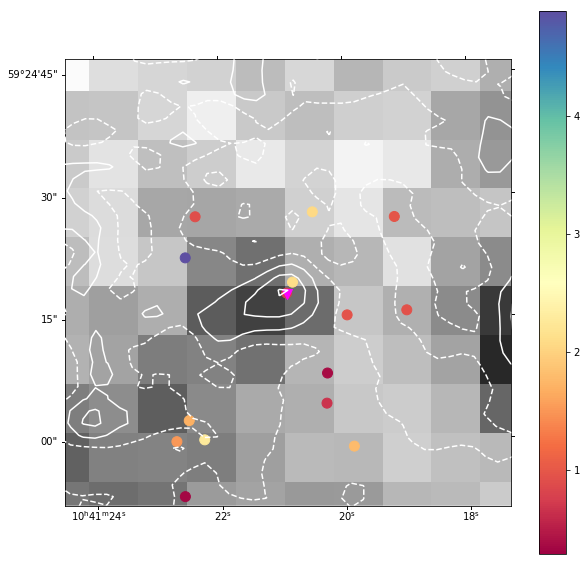

plotting 29 sources
using redshift
plotting 1 sources


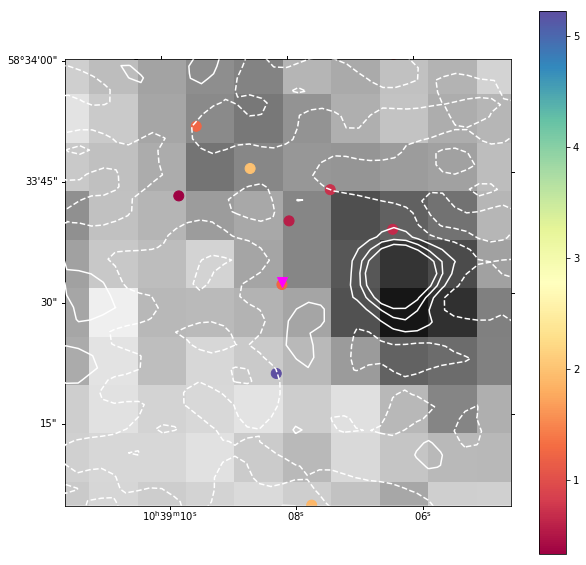

plotting 44 sources
using redshift
plotting 1 sources


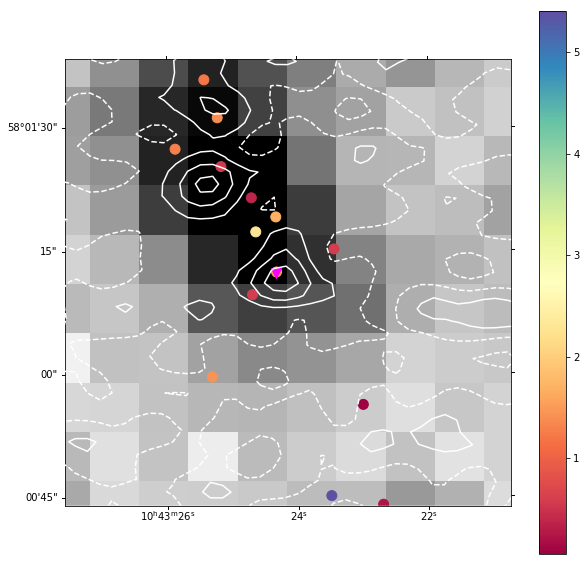

plotting 28 sources
using redshift
plotting 2 sources


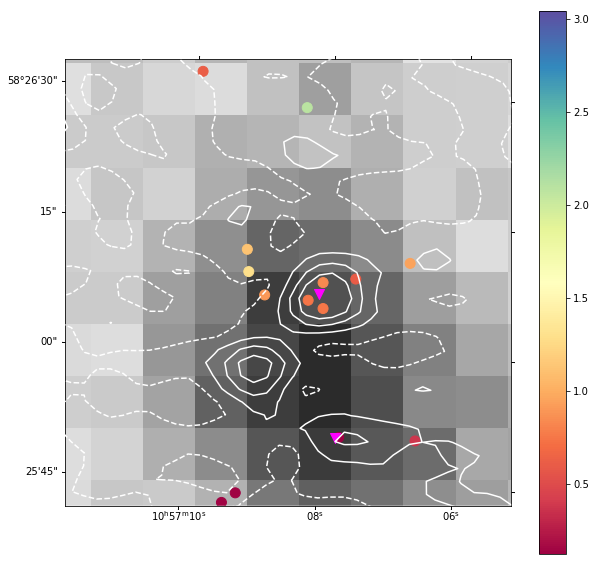

plotting 32 sources
using redshift
plotting 2 sources


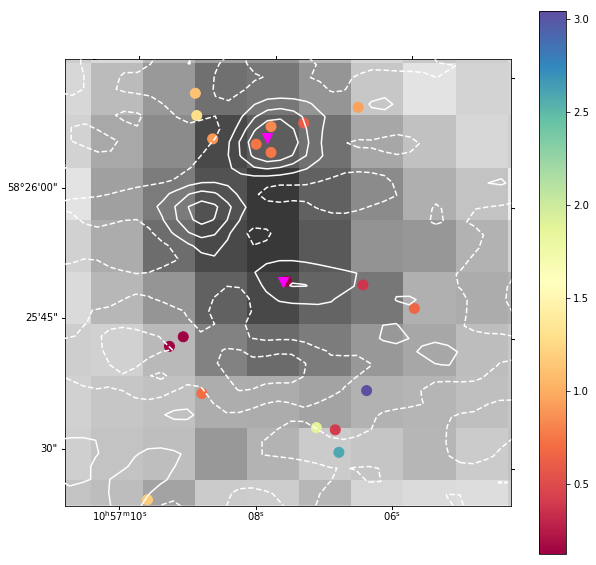

IndexError: index -1 is out of bounds for axis 0 with size 0

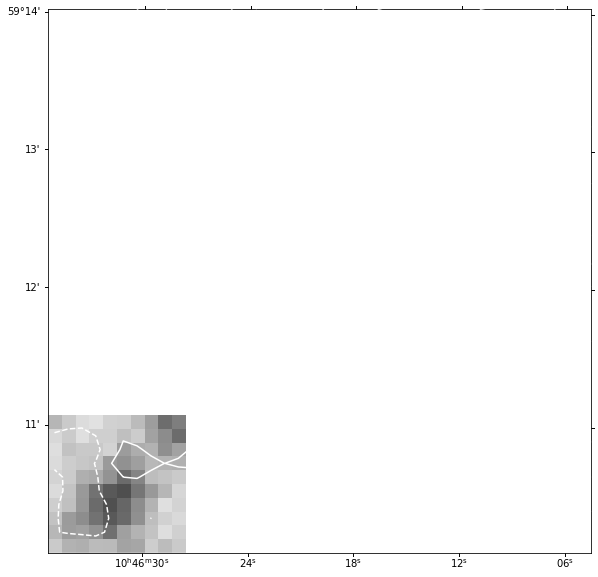

In [557]:
for n in range(len(mrr)):
    plot_figure(im250,[masterlist,mrr],w_250,mrr[n]['ra'],mrr[n]['dec'],plot_params,contour_data=[radim_data,radim_wcs])

